# Table of contents

- [Data Preparation](#Data-Preparation)
- [SVM Method](#SVM-Method)
- [Logistic Regression Method](#Logistic-Regression-Method)
- [Random Forest Method](#Random-Forest-Method)
- [KNN Method](#KNN-Method)

## Notice: This ipynb file must be run after 'DataPreprocessing.ipynb', or the training data and test data cannot be loaded.

# Data Preparation

## Import necessary packages

In [1]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn import svm
import random
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings('ignore')

## Load data

In [2]:
traindata = pd.read_csv('traindata.csv')
testdata = pd.read_csv('testdata.csv')

## Form Xtrain\Xtest\Ytrain\Ytest as we did in preprocessing part(make sure to run smoothly)

In [3]:
##train set
trMOM = traindata.MOM.values
trRSI = traindata.RSI.values
trEMA6 = traindata.EMA6.values
trEMA12 = traindata.EMA12.values
trMACD = traindata.MACD.values
tratr = traindata.atr.values

ss = pd.DataFrame({'MOM':trMOM,'RSI':trRSI,'EMA6':trEMA6,'EMA12':trEMA12,'MACD':trMACD,'ATR':tratr})

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
##Standlization
scaler = StandardScaler()
scaler.fit(ss)
trans_ss = scaler.transform(ss)
##PCA
pca = PCA(n_components=3)
newss = pca.fit_transform(trans_ss)

##print pca score
print(pca.explained_variance_ratio_)

##test set
teMOM = testdata.MOM.values
teRSI = testdata.RSI.values
teEMA6 = testdata.EMA6.values
teEMA12 = testdata.EMA12.values
teMACD = testdata.MACD.values
teatr = testdata.atr.values

xx = pd.DataFrame({'MOM':teMOM,'RSI':teRSI,'EMA6':teEMA6,'EMA12':teEMA12,'MACD':teMACD,'ATR':teatr})
##implement pca to test set
trans_xx = scaler.transform(xx)
newxx = pca.transform(trans_xx)

traindata = traindata.reset_index(drop=True)   
Ytrain = []
for i in range(0,len(traindata)):
    if i%10 == 9:
        if traindata.loc[i,'close'] > traindata.loc[i-4,'close']:
            Ytrain.append(1)
        else:
            Ytrain.append(-1)   


testdata = testdata.reset_index(drop=True)
Ytest = []
for i in range(0,len(testdata)):
    if i%10 == 9:
        if testdata.loc[i,'close'] > testdata.loc[i-4,'close']:
            Ytest.append(1)
        else:
            Ytest.append(-1)

Xtrain = []
for i in range(0,len(newss)):
    if i%10 == 4:
        temp = []
        for j in range(4,-1,-1): 
            temp.append(newss[i-j,0])
            temp.append(newss[i-j,1])
            temp.append(newss[i-j,2])
        Xtrain.append(temp)
    
Xtest = []
for i in range(0,len(newxx)):
    if i%10 == 4:
        temp = []
        for j in range(4,-1,-1): 
            temp.append(newxx[i-j,0])
            temp.append(newxx[i-j,1])
            temp.append(newxx[i-j,2])
        Xtest.append(temp)

[0.48619757 0.3416973  0.09348087]


#### Shown above is the pca score for the most 3 important components

## Randomly select 1000 positive data points and 1000 negative ones to save training time and avoid sample imbalance

In [4]:
random.seed(999)

#select positive data points
id2 = []
for i in range(0,len(Ytrain)):
    if Ytrain[i] == 1:
        id2.append(i)

#select negative data points        
id22 = []
for i in range(0,len(Ytrain)):
    if Ytrain[i] == -1:
        id22.append(i)
        
selectid2 = []
for i in range(0,1000):
    selectid2.append(random.randint(0,len(id2)))

selectid22 = []
for i in range(0,1000):
    selectid22.append(random.randint(0,len(id22)))    

selectXtrain2 = []
selectYtrain2 = []

for i in range(0,1000):
    selectXtrain2.append(Xtrain[id2[selectid2[i]]])
    selectYtrain2.append(Ytrain[id2[selectid2[i]]])
    selectXtrain2.append(Xtrain[id22[selectid22[i]]])
    selectYtrain2.append(Ytrain[id22[selectid22[i]]])

# SVM Method

## Using linear model, set C = 10.0

In [5]:
clf = svm.SVC(kernel='linear',C=10.0)
clf.fit(selectXtrain2,selectYtrain2)

SVC(C=10.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [6]:
clf.score(Xtest,Ytest)

0.5837757133377571

In [7]:
pred_y = clf.predict(Xtest)
conf_mat = confusion_matrix(Ytest, pred_y)
print(conf_mat)

[[14885  7194]
 [10369  9748]]


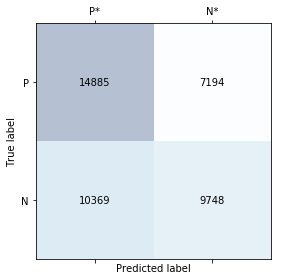

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(4, 4))
ax.matshow(conf_mat, cmap=plt.cm.Blues, alpha=0.3)

for i in range(conf_mat.shape[0]):
    for j in range(conf_mat.shape[1]):
        ax.text(x=j, y=i, s=conf_mat[i, j], va='center', ha='center')
plt.xticks([0, 1], ['P*', 'N*'])
plt.yticks([0, 1], ['P', 'N'])

plt.xlabel('Predicted label')
plt.ylabel('True label')

plt.tight_layout()
#plt.savefig('con_matrix_svm1.png', dpi=300)
plt.show()

## Using GridSearch to pick parameters

In [9]:
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC

pipe_svc = make_pipeline(SVC(random_state=999))

param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]

param_grid = [{'svc__C': param_range, 
               'svc__kernel': ['linear']},
              {'svc__C': param_range, 
               'svc__gamma': param_range, 
               'svc__kernel': ['rbf']}]

gs = GridSearchCV(estimator=pipe_svc, 
                  param_grid=param_grid, 
                  scoring='accuracy', 
                  cv=10,
                  n_jobs=-1)
gs = gs.fit(selectXtrain2,selectYtrain2)
print(gs.best_score_)
print(gs.best_params_)

0.6025
{'svc__C': 1000.0, 'svc__gamma': 0.01, 'svc__kernel': 'rbf'}


In [10]:
clf2 = svm.SVC(kernel='rbf',C=100.0,gamma=0.01)
clf2.fit(selectXtrain2,selectYtrain2)
print(clf2.score(Xtest,Ytest))
pred_y2 = clf2.predict(Xtest)
conf_mat2 = confusion_matrix(Ytest, pred_y2)
print(conf_mat2)
print(classification_report(Ytest, pred_y2))

0.6101052232439094
[[14900  7179]
 [ 9273 10844]]
              precision    recall  f1-score   support

          -1       0.62      0.67      0.64     22079
           1       0.60      0.54      0.57     20117

    accuracy                           0.61     42196
   macro avg       0.61      0.61      0.61     42196
weighted avg       0.61      0.61      0.61     42196



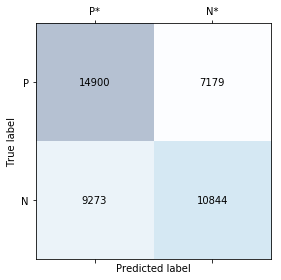

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(4, 4))
ax.matshow(conf_mat2, cmap=plt.cm.Blues, alpha=0.3)

for i in range(conf_mat2.shape[0]):
    for j in range(conf_mat2.shape[1]):
        ax.text(x=j, y=i, s=conf_mat2[i, j], va='center', ha='center')
plt.xticks([0, 1], ['P*', 'N*'])
plt.yticks([0, 1], ['P', 'N'])

plt.xlabel('Predicted label')
plt.ylabel('True label')

plt.tight_layout()
#plt.savefig('con_matrix_svm2.png', dpi=300)
plt.show()

# Logistic Regression Method

## Get the parameters for the Logistics Regression Method

In [12]:
penaltys = ['l1','l2']
Cs = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
#param_grid = dict(penalty = penaltys, C = Cs)
pipe_lr = make_pipeline(LogisticRegression(random_state=1))
pipe_lr.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'logisticregression', 'logisticregression__C', 'logisticregression__class_weight', 'logisticregression__dual', 'logisticregression__fit_intercept', 'logisticregression__intercept_scaling', 'logisticregression__l1_ratio', 'logisticregression__max_iter', 'logisticregression__multi_class', 'logisticregression__n_jobs', 'logisticregression__penalty', 'logisticregression__random_state', 'logisticregression__solver', 'logisticregression__tol', 'logisticregression__verbose', 'logisticregression__warm_start'])

In [13]:
gs = GridSearchCV(pipe_lr, 
                  param_grid={'logisticregression__C':Cs, 'logisticregression__penalty':penaltys}, 
                  cv=10,
                  scoring = 'accuracy',
                  n_jobs=-1)
warnings.filterwarnings("ignore")
gs = gs.fit(selectXtrain2,selectYtrain2)
print(gs.best_score_)
print(gs.best_params_)

0.554
{'logisticregression__C': 100.0, 'logisticregression__penalty': 'l2'}


In [14]:
gs.fit(selectXtrain2,selectYtrain2)
print(gs.score(Xtest,Ytest))
pred_y2 = gs.predict(Xtest)
conf_mat2 = confusion_matrix(Ytest, pred_y2)
print(conf_mat2)
print(classification_report(Ytest, pred_y2))

0.5640108067115366
[[13504  8575]
 [ 9822 10295]]
              precision    recall  f1-score   support

          -1       0.58      0.61      0.59     22079
           1       0.55      0.51      0.53     20117

    accuracy                           0.56     42196
   macro avg       0.56      0.56      0.56     42196
weighted avg       0.56      0.56      0.56     42196



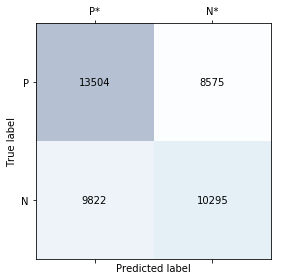

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(4, 4))
ax.matshow(conf_mat2, cmap=plt.cm.Blues, alpha=0.3)

for i in range(conf_mat2.shape[0]):
    for j in range(conf_mat2.shape[1]):
        ax.text(x=j, y=i, s=conf_mat2[i, j], va='center', ha='center')
plt.xticks([0, 1], ['P*', 'N*'])
plt.yticks([0, 1], ['P', 'N'])

plt.xlabel('Predicted label')
plt.ylabel('True label')

plt.tight_layout()
#plt.savefig('con_matrix_lr.png', dpi=300)
plt.show()

# Random Forest Method

In [16]:
forest = RandomForestClassifier(criterion='gini', n_estimators=10, max_features=3, max_depth=3, random_state=1, n_jobs=2)
forest.fit(selectXtrain2, selectYtrain2)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=3, max_features=3,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=2,
                       oob_score=False, random_state=1, verbose=0,
                       warm_start=False)

In [17]:
forest.score(Xtest,Ytest)

0.5553606976964641

In [18]:
pred_y = forest.predict(Xtest)
conf_mat = confusion_matrix(Ytest, pred_y)
print(conf_mat)

[[15432  6647]
 [12115  8002]]


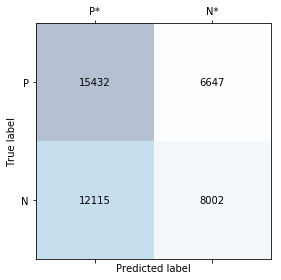

In [20]:
%matplotlib inline
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(4, 4))
ax.matshow(conf_mat, cmap=plt.cm.Blues, alpha=0.3)

for i in range(conf_mat.shape[0]):
    for j in range(conf_mat.shape[1]):
        ax.text(x=j, y=i, s=conf_mat[i, j], va='center', ha='center')
plt.xticks([0, 1], ['P*', 'N*'])
plt.yticks([0, 1], ['P', 'N'])

plt.xlabel('Predicted label')
plt.ylabel('True label')

plt.tight_layout()
#plt.savefig('con_matrix_rf1.png', dpi=300)
plt.show()

## Using GridSearch to pick parameters

In [21]:
from sklearn.model_selection import GridSearchCV
pipe_rf = RandomForestClassifier()

param_range = [2, 3, 4]
param_grid = {'max_depth': param_range, 'criterion':['gini','entropy'], 'n_estimators': [10, 30, 50]}
gs = GridSearchCV(estimator=pipe_rf, 
                  param_grid=param_grid, 
                  scoring='accuracy', 
                  cv=10,
                  n_jobs=-1)
gs = gs.fit(selectXtrain2,selectYtrain2)
print(gs.best_score_)
print(gs.best_params_)

0.5710000000000001
{'criterion': 'entropy', 'max_depth': 4, 'n_estimators': 50}


In [22]:
rf2 = RandomForestClassifier(criterion='entropy', n_estimators=30, max_features=3, max_depth=3, random_state=1, n_jobs=-1)
rf2.fit(selectXtrain2, selectYtrain2)
print(rf2.score(Xtest,Ytest))
pred_y2 = rf2.predict(Xtest)
conf_mat2 = confusion_matrix(Ytest, pred_y2)
print(conf_mat2)
print(classification_report(Ytest, pred_y2))

0.561309128827377
[[15123  6956]
 [11555  8562]]
              precision    recall  f1-score   support

          -1       0.57      0.68      0.62     22079
           1       0.55      0.43      0.48     20117

    accuracy                           0.56     42196
   macro avg       0.56      0.56      0.55     42196
weighted avg       0.56      0.56      0.55     42196



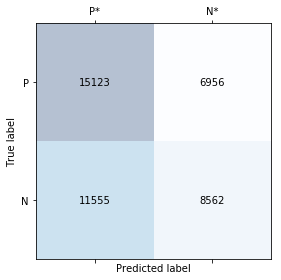

In [23]:
%matplotlib inline
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(4, 4))
ax.matshow(conf_mat2, cmap=plt.cm.Blues, alpha=0.3)

for i in range(conf_mat2.shape[0]):
    for j in range(conf_mat2.shape[1]):
        ax.text(x=j, y=i, s=conf_mat2[i, j], va='center', ha='center')
plt.xticks([0, 1], ['P*', 'N*'])
plt.yticks([0, 1], ['P', 'N'])

plt.xlabel('Predicted label')
plt.ylabel('True label')

plt.tight_layout()
#plt.savefig('con_matrix_rf2.png', dpi=300)
plt.show()

# KNN Method

In [24]:
X_train, X_test, y_train, y_test = selectXtrain2, Xtest, selectYtrain2, Ytest 

from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline

pipe_knn = make_pipeline(StandardScaler(),
                       KNeighborsClassifier(n_neighbors=10, 
                           p=2, 
                           metric='minkowski'))

pipe_knn.fit(X_train, y_train)
y_pred = pipe_knn.predict(X_test)
print('Training Accuracy: %.3f' % pipe_knn.score(X_train, y_train))
print('Test Accuracy: %.3f' % pipe_knn.score(X_test, y_test))

Training Accuracy: 0.689
Test Accuracy: 0.559


## Learning curve

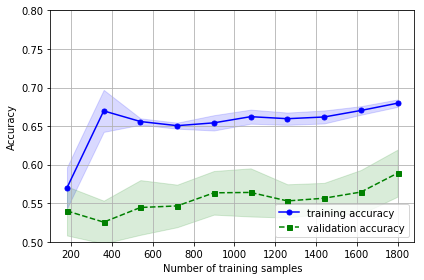

In [25]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores =\
                learning_curve(estimator=pipe_knn,
                               X=X_train,
                               y=y_train,
                               train_sizes=np.linspace(0.1, 1.0, 10),
                               cv=10,
                               n_jobs=1)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean,
         color='blue', marker='o',
         markersize=5, label='training accuracy')

plt.fill_between(train_sizes,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean,
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='validation accuracy')

plt.fill_between(train_sizes,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')

plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.5, 0.8])
plt.tight_layout()
#plt.savefig('learning_curve', dpi=300)
plt.show()

## Validation curve

In [26]:
pipe_knn.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'standardscaler', 'kneighborsclassifier', 'standardscaler__copy', 'standardscaler__with_mean', 'standardscaler__with_std', 'kneighborsclassifier__algorithm', 'kneighborsclassifier__leaf_size', 'kneighborsclassifier__metric', 'kneighborsclassifier__metric_params', 'kneighborsclassifier__n_jobs', 'kneighborsclassifier__n_neighbors', 'kneighborsclassifier__p', 'kneighborsclassifier__weights'])

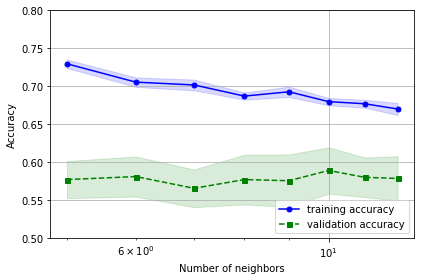

In [27]:
from sklearn.model_selection import validation_curve

param_range = [i for i in range(5,13)]
train_scores, test_scores = validation_curve(
                estimator=pipe_knn, 
                X=X_train, 
                y=y_train, 
                param_name='kneighborsclassifier__n_neighbors', 
                param_range=param_range,
                cv=10)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(param_range, train_mean, 
         color='blue', marker='o', 
         markersize=5, label='training accuracy')

plt.fill_between(param_range, train_mean + train_std,
                 train_mean - train_std, alpha=0.15,
                 color='blue')

plt.plot(param_range, test_mean, 
         color='green', linestyle='--', 
         marker='s', markersize=5, 
         label='validation accuracy')

plt.fill_between(param_range, 
                 test_mean + test_std,
                 test_mean - test_std, 
                 alpha=0.15, color='green')

plt.grid()
plt.xscale('log')
plt.legend(loc='lower right')
plt.xlabel('Number of neighbors')
plt.ylabel('Accuracy')
plt.ylim([0.5, 0.8])
plt.tight_layout()
#plt.savefig('validation_curve.png', dpi=300)
plt.show()

## Confusion matrix

In [28]:
from sklearn.metrics import confusion_matrix
y_pred = pipe_knn.predict(X_test)
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print(confmat)

[[14532  7547]
 [11079  9038]]


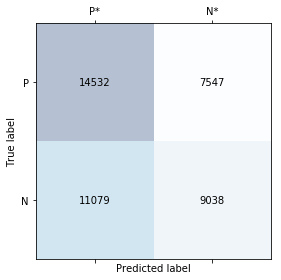

In [29]:
%matplotlib inline
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(4, 4))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)

for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')
plt.xticks([0, 1], ['P*', 'N*'])
plt.yticks([0, 1], ['P', 'N'])

plt.xlabel('Predicted label')
plt.ylabel('True label')

plt.tight_layout()
#plt.savefig('con_matrix.png', dpi=300)
plt.show()

## Precision, recall and F1-score

In [30]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score, f1_score
print('Precision: %.3f' % precision_score(y_true=y_test, y_pred=y_pred))
print('Recall: %.3f' % recall_score(y_true=y_test, y_pred=y_pred))
print('F1: %.3f' % f1_score(y_true=y_test, y_pred=y_pred))

Precision: 0.545
Recall: 0.449
F1: 0.493


## Gridsearch

In [31]:
pipe_knngrid = make_pipeline(StandardScaler(),
                         KNeighborsClassifier())
pipe_knngrid.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'standardscaler', 'kneighborsclassifier', 'standardscaler__copy', 'standardscaler__with_mean', 'standardscaler__with_std', 'kneighborsclassifier__algorithm', 'kneighborsclassifier__leaf_size', 'kneighborsclassifier__metric', 'kneighborsclassifier__metric_params', 'kneighborsclassifier__n_jobs', 'kneighborsclassifier__n_neighbors', 'kneighborsclassifier__p', 'kneighborsclassifier__weights'])

In [32]:
from sklearn.model_selection import GridSearchCV
param_range = [i for i in range(5, 21)]

param_grid = {'kneighborsclassifier__n_neighbors':param_range}
       
gs = GridSearchCV(estimator=pipe_knngrid, 
                  param_grid=param_grid, 
                  scoring='accuracy', 
                  cv=10,
                  n_jobs=-1)
gs = gs.fit(X_train, y_train)
print('Best score: %.5f' % gs.best_score_)
print(gs.best_params_)

Best score: 0.59200
{'kneighborsclassifier__n_neighbors': 14}


### Training and test accuracy under '14 neighbors'

In [33]:
pipe_knn_final = make_pipeline(StandardScaler(),
                       gs.best_estimator_)

pipe_knn_final.fit(X_train, y_train)
y_pred = pipe_knn_final.predict(X_test)
print('Training Accuracy: %.3f' % pipe_knn_final.score(X_train, y_train))
print('Test Accuracy: %.3f' % pipe_knn_final.score(X_test, y_test))

Training Accuracy: 0.664
Test Accuracy: 0.560


### Precision, recall and F1-score under '14 neighbors'

In [34]:
print('Precision: %.3f' % precision_score(y_true=y_test, y_pred=y_pred))
print('Recall: %.3f' % recall_score(y_true=y_test, y_pred=y_pred))
print('F1: %.3f' % f1_score(y_true=y_test, y_pred=y_pred))

Precision: 0.546
Recall: 0.459
F1: 0.499


In [35]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.57      0.65      0.61     22079
           1       0.55      0.46      0.50     20117

    accuracy                           0.56     42196
   macro avg       0.56      0.56      0.55     42196
weighted avg       0.56      0.56      0.56     42196

